# Recommender System for Million Song Dataset

In [1]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=40f1aa20d169e42550d67a6f36a940f50369ad1ae9e39a181807010c83b1af36
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

### exploratory data analysis

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path="/content/drive/MyDrive/Colab Notebooks/million-song-dataset_sample.csv"
data=pd.read_csv(path)

In [7]:
data.shape

(126704, 9)

In [8]:
data.head()

,user,song,play_count,title,release,artist_name,artist_familiarity,artist_hotttnesss,year
0,7452,4673,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,0.633119,0.417718,1976
1,2643,4673,66,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,0.633119,0.417718,1976
2,3556,4673,6,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,0.633119,0.417718,1976
3,9592,4673,3,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,0.633119,0.417718,1976
4,8133,4673,1,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,0.633119,0.417718,1976


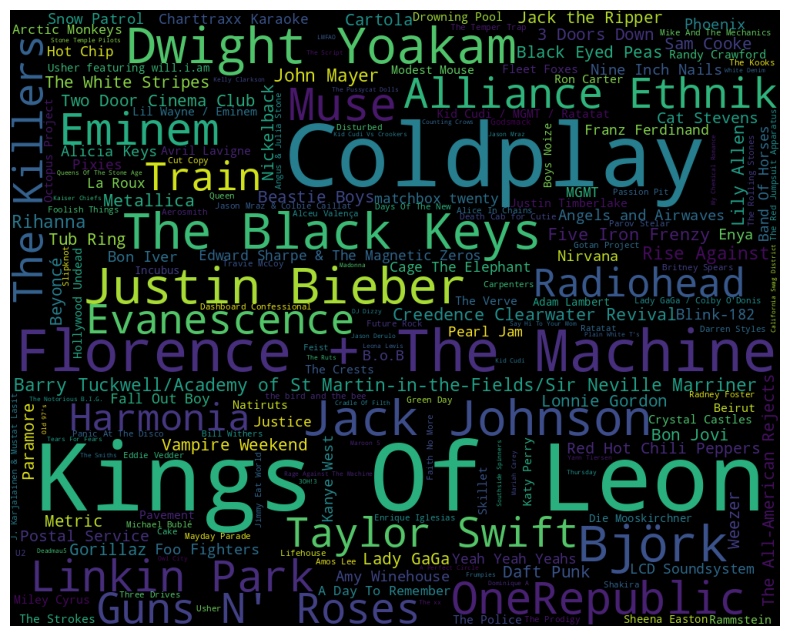

In [9]:
artist_playcounts = {}
for artist, group in data.groupby('artist_name'):
    artist_playcounts[artist] = group['play_count'].sum()

plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(artist_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [10]:
len(artist_playcounts)

2235

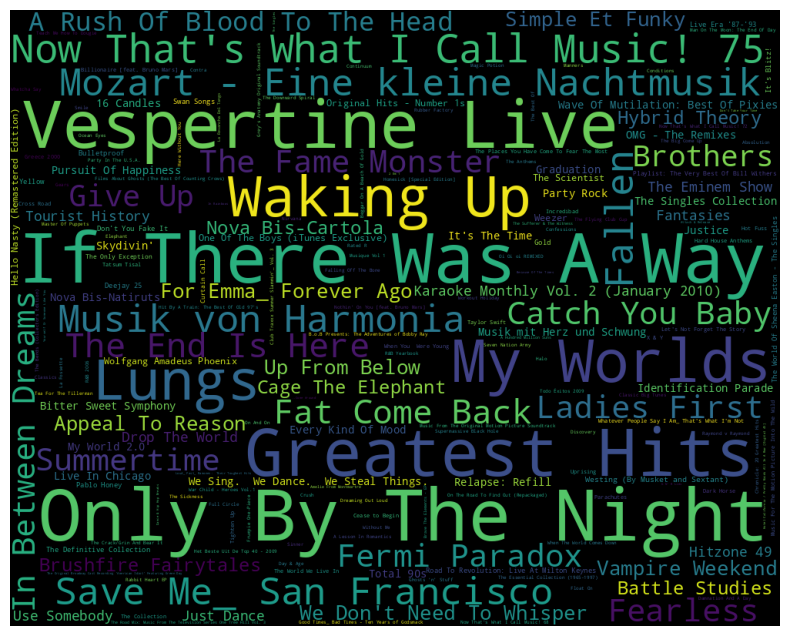

In [11]:
release_playcounts = {}
for release, group in data.groupby('release'):
    release_playcounts[release] = group['play_count'].sum()


plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(release_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [12]:
len(release_playcounts)

3093

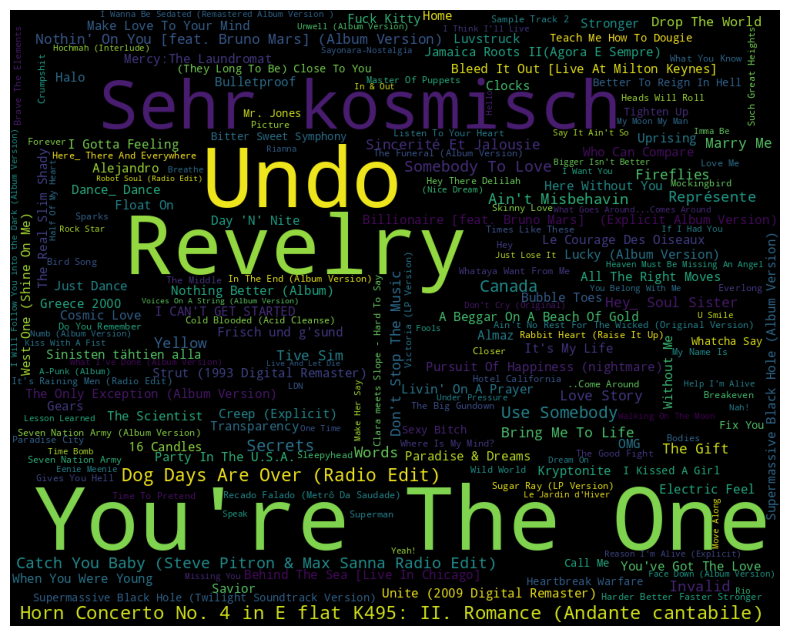

In [13]:
song_playcounts = {}
for song, group in data.groupby('title'):
    song_playcounts[song] = group['play_count'].sum()


plt.figure(figsize=(12, 8))
wc = WordCloud(width=1000, height=800)
wc.generate_from_frequencies(song_playcounts)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [14]:
len(song_playcounts)

4107

### step1:

In [15]:
# Rank-based recommendation
def recommendation_basedonPopularity(df, N=5):
    my_df = df.copy()

    song_peopleplay = {}
    for song, group in my_df.groupby('title'):
        song_peopleplay[song] = group['user'].count()

    sorted_dict = sorted(song_peopleplay.items(), key=lambda x: x[1], reverse=True)[:N]

    return list(dict(sorted_dict).keys())

In [16]:
recommendation_basedonPopularity(data, N=5)

['Use Somebody',
 'Sehr kosmisch',
 'Dog Days Are Over (Radio Edit)',
 'Yellow',
 'Undo']

### step2:

In [17]:
(data['play_count'].min(), data['play_count'].max())

(1, 1890)

In [18]:
user_averageScore = {}
for user, group in data.groupby('user'):
    user_averageScore[user] = group['play_count'].mean()

In [19]:
data['rating'] = data.apply(lambda x: np.log(2 + x.play_count / user_averageScore[x.user]), axis=1)

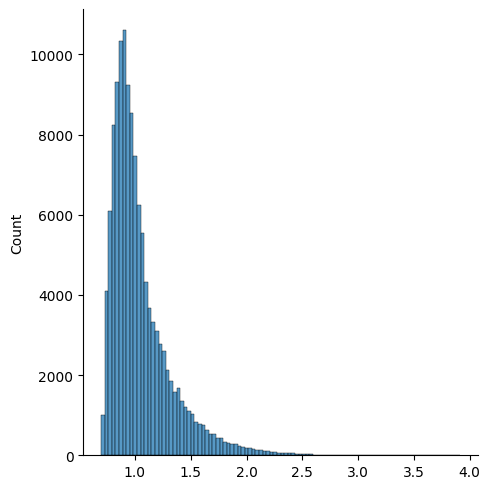

In [20]:
sns.displot(data['rating'].values, bins=100)
plt.show()

In [21]:
# 得到用户-音乐评分矩阵
user_item_rating = data[['user', 'song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'song': 'item'})

In [22]:
user_item_rating.head()

,user,item,rating
0,7452,4673,1.139434
1,2643,4673,1.119890
2,3556,4673,1.312186
3,9592,4673,1.326506
4,8133,4673,1.066351


In [23]:
user_item_rating.shape

(126704, 3)

In [24]:
# itemCF

reader = Reader(line_format='user item rating', sep=',')
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
kf = KFold(n_splits=5)

knn_itemcf = KNNBasic(k=20, sim_options={'user_based': False})

for trainset, testset in kf.split(raw_data):
    knn_itemcf.fit(trainset)
    predictions = knn_itemcf.test(testset)
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2854
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2814
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2859
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2786
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2804


In [25]:

user_songs = {}
for user, group in user_item_rating.groupby('user'):
    user_songs[user] = group['item'].values.tolist()


songs = user_item_rating['item'].unique().tolist()


songID_titles = {}
for index in data.index:
    songID_titles[data.loc[index, 'song']] = data.loc[index, 'title']

In [26]:
user_item_rating.head()

,user,item,rating
0,7452,4673,1.139434
1,2643,4673,1.119890
2,3556,4673,1.312186
3,9592,4673,1.326506
4,8133,4673,1.066351


In [27]:
user_item_rating.shape

(126704, 3)

In [28]:
len(user_songs)

4132

In [29]:
# itemCF recommendation
def recommendation_basedonItemCF(userID, N=5):

    used_items = user_songs[userID]


    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_itemcf.predict(userID, item).est


    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])

    song_topN = song_ids
    return song_topN

In [30]:
recommendation_basedonItemCF(6892)

{34079: 1.6023540575456954,
 79570: 1.6023540575456954,
 62977: 1.6023540575456954,
 38127: 1.6023540575456954,
 108476: 1.6023540575456954}

In [31]:
# userCF

reader = Reader(line_format='user item rating', sep=',')

raw_data = Dataset.load_from_df(user_item_rating, reader=reader)

kf = KFold(n_splits=5)

knn_usercf = KNNBasic(k=20, sim_options={'user_based': True})

for trainset, testset in kf.split(raw_data):
    knn_usercf.fit(trainset)
    predictions = knn_usercf.test(testset)
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2812
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2827
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2829
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2844
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2811


In [32]:
# userCF recommendation
def recommendation_basedonUserCF(userID, N=5):

    used_items = user_songs[userID]

    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_usercf.predict(userID, item).est

    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    song_topN = [songID_titles[s] for s in song_ids.keys()]

    return song_topN


In [33]:
recommendation_basedonUserCF(6892)

['In the Summertime',
 'Revizor',
 'Nightmare',
 'Fuck You (Album Version)',
 'Four Cars Ago']

### 3. SVD

In [34]:

reader = Reader(line_format='user item rating', sep=',')

raw_data = Dataset.load_from_df(user_item_rating, reader=reader)

kf = KFold(n_splits=5)

algo = SVD(n_factors=40, biased=True)

for trainset, testset in kf.split(raw_data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.2780
RMSE: 0.2865
RMSE: 0.2802
RMSE: 0.2780
RMSE: 0.2785


In [35]:
# SVD recommendation
def recommendation_basedonMF(userID, N=5):

    used_items = user_songs[userID]

    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = algo.predict(userID, item).est

    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    song_topN = song_ids

    return song_topN



In [36]:
recommendation_basedonMF(6892)

{2380: 1.529670660436287,
 17982: 1.4588911477969413,
 90883: 1.4524214465640406,
 92145: 1.447989157394531,
 20253: 1.434298199213183}

In [37]:

rank_data = data.copy()

rank_data.drop('title', axis=1, inplace=True)


release_encoder = LabelEncoder()
rank_data['release'] = release_encoder.fit_transform(rank_data['release'].values)

artist_name_encoder = LabelEncoder()
rank_data['artist_name'] = artist_name_encoder.fit_transform(rank_data['artist_name'].values)


rank_data['rating'] = rank_data['rating'].apply(lambda x: 0 if x < 0.9 else 1)

rank_data.head()

,user,song,play_count,release,artist_name,artist_familiarity,artist_hotttnesss,year,rating
0,7452,4673,2,895,1476,0.633119,0.417718,1976,1
1,2643,4673,66,895,1476,0.633119,0.417718,1976,1
2,3556,4673,6,895,1476,0.633119,0.417718,1976,1
3,9592,4673,3,895,1476,0.633119,0.417718,1976,1
4,8133,4673,1,895,1476,0.633119,0.417718,1976,1


### GBDT and LR

In [38]:
# Split the dataset into a GBDT training set and an LR training set.
X_gbdt, X_lr, y_gbdt, y_lr = train_test_split(rank_data.iloc[:, :-1].values, rank_data.iloc[:, -1].values, test_size=0.5)

In [39]:
X_gbdt.shape,X_lr.shape

((63352, 8), (63352, 8))

In [40]:
depth = 6
n_estimator = 200

print('current n_estimators=', n_estimator)

gbdt = GradientBoostingClassifier(n_estimators=n_estimator, max_depth=depth, min_samples_split=3, min_samples_leaf=2)
gbdt.fit(X_gbdt, y_gbdt)

print('Currrent training of gbdt is done！')

current n_estimators= 200
Currrent training of gbdt is done！


In [41]:
onehot = OneHotEncoder()
onehot.fit(gbdt.apply(X_gbdt).reshape(-1, n_estimator))

# Perform one-hot encoding on the GBDT results, and then train the logistic regression model.
lr = LogisticRegression()
lr.fit(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)), y_lr)

print('Current training of lr is done！')

Current training of lr is done！


In [42]:
lr_pred = lr.predict(onehot.transform(gbdt.apply(X_lr).reshape(-1, n_estimator)))
auc_score = roc_auc_score(y_lr, lr_pred)

print('current n_estimators:', n_estimator,'current auc:', auc_score)
print('#'*40)

current n_estimators: 200 current auc: 0.8519814088755144
########################################


In [43]:
# recommender
def recommendation(userID):
    # recall 50 songs
    recall = recommendation_basedonItemCF(userID, 50)


    print('The recall is done！')

    # Based on the recalled song information, generate the feature vectors.
    feature_lines = []
    for song in recall.keys():
        feature = rank_data[rank_data.song==song].values[0]
        feature = feature[:-1]
        feature[0] = userID
        feature_lines.append(feature)

    # use gbdt+lr calculate the weights
    weights = lr.predict_proba(onehot.transform(gbdt.apply(feature_lines).reshape(-1, n_estimator)))[:, 1]

    #print(weights.shape)
    print('Sorting weights calculation is done!')

    # caulcaute final score
    score = {}
    i = 0
    for song in recall.keys():
        score[song] = recall[song] * weights[i]
        i += 1


    # id of top5 songs
    song_ids = dict(sorted(score.items(), key=lambda x: x[1], reverse=True)[: 5])
    # name of top5 songs
    song_topN = [songID_titles[s] for s in song_ids.keys()]

    print('The final recommendation list is')

    return song_topN


In [44]:
recommendation(6892)

The recall is done！
Sorting weights calculation is done!
The final recommendation list is


['Sheeszalitch',
 'MIC (Speak Life Album Version)',
 'Miss Gorgeous',
 "We Her Majesty's Prisoners",
 'Heavenbound']